In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset

In [113]:
ds = load_dataset("microsoft/cats_vs_dogs", split='train')

In [114]:
print(ds)

Dataset({
    features: ['image', 'labels'],
    num_rows: 23410
})


In [115]:
ds.shape

(23410, 2)

In [116]:
print("Mix of our dataset :")
print(f"{np.mean(ds['labels'])*100:.2f}% of dog images")
print(f"{(1 - np.mean(ds['labels']))*100:.2f}% of cat images")

Mix of our dataset :
49.85% of dog images
50.15% of cat images


In [117]:
np.mean(ds['labels'])

0.49846219564288763

In [118]:
label_catdogs = {
    0:"Cat",
    1:"Dog"
    }

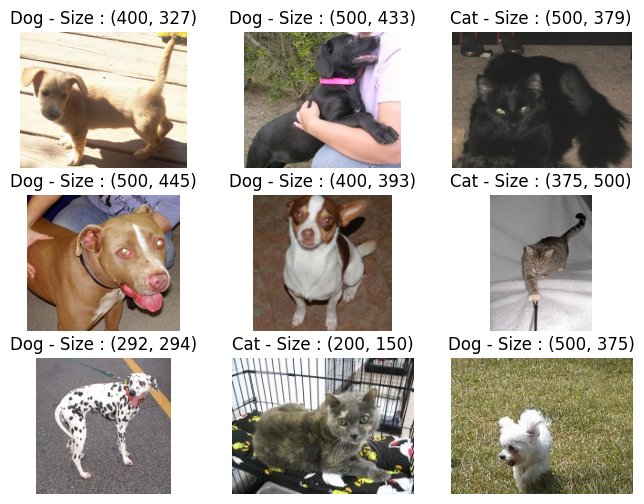

In [119]:
label_catdogs = {
    0:"Cat",
    1:"Dog"
}

fig, ax = plt.subplots(3, 3, figsize=(8, 6))
ax = ax.flatten()

for i in range(9):
    randomInt = np.random.randint(ds.shape[0])
    ax[i].set_title(f"{label_catdogs[ds[randomInt]['labels']]} - Size : {ds[randomInt]['image'].size}")
    ax[i].axis("off")
    ax[i].imshow(ds[randomInt]["image"])
    
plt.axis("off")
plt.show()

---

RESIZING THE IMAGES

In [120]:
images_sizes = [ds[i]['image'].size for i in range(ds.shape[0])]

In [121]:
widths, heights = zip(*images_sizes)

average_width, average_height = int(sum(widths) / len(widths)), int(sum(heights) / len(heights))

print(f"Average size of the images from the dataset is {average_width, average_height}")

Average size of the images from the dataset is (409, 364)


In [122]:
average_size = (409, 364)

In [123]:
# ds['image']

In [124]:
image = ds[0]['image'] # y accéder de cette manière et surtout pas comme ça : ds['image'][0]

In [125]:
desired_size = (128, 128)

In [126]:
import torch
from torchvision import io, transforms

# Définir la transformation de redimensionnement avec l'interpolation 'nearest'
resize_transform = transforms.Resize(desired_size, interpolation=transforms.InterpolationMode.NEAREST)

transform = transforms.Compose([
    transforms.ToTensor()  # Convertit l'image PIL en tenseur PyTorch
]) # normalise directement entre 0 et 1

In [133]:
def resize_and_convert(example):
    image = example['image']
    
    # Convertir en RGB si nécessaire
    if image.mode == "L" or image.mode == "CMYK":
        image = image.convert('RGB')

    # Appliquer la transformation de redimensionnement
    image = resize_transform(image)  

    return {"image": image}  # Retourner l'image modifiée

# Appliquer la fonction à tout le dataset
ds = ds.map(resize_and_convert)

Map:   0%|          | 0/23410 [00:00<?, ? examples/s]

In [ ]:
# images_sizes = [ds[i]['image'].size for i in range(ds.shape[0])]

In [ ]:
#widths, heights = zip(*images_sizes)
#
#average_width, average_height = int(sum(widths) / len(widths)), int(sum(heights) / len(heights))
#
#print(f"Average size of the images from the dataset is {average_width, average_height}")

Average size of the images from the dataset is (128, 128)


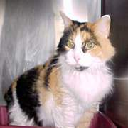

In [138]:
ds[400]['image']

---

Dataset Loaders

In [ ]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from PIL import Image

In [140]:
# Diviser le dataset en ensembles d'entraînement et de test
datasets = ds.train_test_split(test_size=0.3, seed=42)
train_dataset = datasets['train']
test_dataset = datasets['test']

In [ ]:
train_dataset['image']

Dataset({
    features: ['image', 'labels'],
    num_rows: 16387
})

In [142]:
print(f"Shape of X_train : {train_dataset.shape[0]}")
print(f"Shape of X_test : {test_dataset.shape[0]}")
print(f"Shape of y_train : {train_dataset.shape[0]}")
print(f"Shape of y_test : {test_dataset.shape[0]}")

Shape of X_train : 16387
Shape of X_test : 7023
Shape of y_train : 16387
Shape of y_test : 7023


In [143]:
print("Mix of our dataset :")
print(f"{(1-(np.sum((train_dataset['labels']))/train_dataset.shape[0]))*100:.2f}% of cat images in train set")
print(f"{(1-(np.sum((test_dataset['labels']))/test_dataset.shape[0]))*100:.2f}% of cat images in test set")

Mix of our dataset :
50.45% of cat images in train set
49.45% of cat images in test set


In [144]:
# Définir les transformations pour l'entraînement
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),  # Retourne l'image horizontalement avec une probabilité de 0.5
    transforms.RandomVerticalFlip(p=0.5),    # Retourne l'image verticalement avec une probabilité de 0.5
    transforms.RandomRotation(degrees=15),  # Effectue une rotation aléatoire jusqu'à 15 degrés
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Modifie aléatoirement la luminosité, le contraste, etc.
    transforms.ToTensor(),  # Convertit l'image en tenseur PyTorch
])

# Définir les transformations pour le test (généralement sans augmentation)
test_transforms = transforms.Compose([
    transforms.ToTensor(),  # Convertit l'image en tenseur PyTorch
])

In [145]:
def transform_image(batch, transform):
    images = []
    for image_data in batch['image']:
        if isinstance(image_data, np.ndarray):  
            image = Image.fromarray(image_data)  # Convertir NumPy -> PIL
        elif isinstance(image_data, Image.Image):  
            image = image_data  # L'image est déjà en format PIL, ne pas rouvrir
        else:
            image = Image.open(image_data)  # Ouvrir normalement si c'est un fichier ou BytesIO
        
        image = transform(image)  # Appliquer la transformation
        images.append(image)

    return {'image': images, 'labels': batch['labels']}  


In [146]:
# Appliquer les transformations aux datasets
train_dataset.set_transform(lambda x: transform_image(x, train_transforms))
test_dataset.set_transform(lambda x: transform_image(x, test_transforms))

In [ ]:
# Créer des DataLoader pour les ensembles d'entraînement et de test
dataloader_train = DataLoader(train_dataset, batch_size=32, shuffle=True)
dataloader_test = DataLoader(test_dataset, batch_size=32, shuffle=False)

---

MODEL

In [155]:
# Définir le modèle CNN
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1) # stride defines the movement of the kernel, 1 per 1 px for this example, padding 1 means that we add 1 column and 1 row to keep the same size
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(16 * 16 * 32, 128)
        self.fc2 = nn.Linear(128, 1)

    def forward(self, x):
        x = torch.relu(self.conv1(x)) # we are taking 3 channels as an entry (RGB), and applying 16 different kernels (which is a set of three different kernel for each of the channel) on it
        x = torch.max_pool2d(x, kernel_size=2, stride=2) # images' size are now 64x64x16, because the 16 kernels from the previous layer "generated" 16 new sets of values for each of the image, and that's what we are giving to the next layer 
        x = torch.relu(self.conv2(x)) # taking the 16 outputs of the previous layer, and applying 32 other kernels on it
        x = torch.max_pool2d(x, kernel_size=2, stride=2) # images' size are now 32x32x32
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.sigmoid(x)

In [166]:
# Instancier le modèle, la fonction de perte et l'optimiseur
model = SimpleCNN()
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [167]:
# Entraîner le modèle
num_epochs = 5
train_losses = []
test_losses = []
accuracies = []

for epoch in range(num_epochs):
    # Mode entraînement
    model.train()
    train_loss = 0.0

    for batch_idx, batch in enumerate(dataloader_train):
        # Forward pass
        images = batch['image']
        labels = batch['labels']

        outputs = model(images).squeeze()
        loss = criterion(outputs, labels.float())

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

        if batch_idx % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx}/{len(dataloader_train)}], Loss: {loss.item():.4f}')

    # Calculer la perte moyenne sur l'ensemble de l'époque d'entraînement
    train_loss /= len(dataloader_train)
    train_losses.append(train_loss)

    # Mode évaluation
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx_test, batch_test in enumerate(dataloader_test):
            images = batch_test['image']
            labels = batch_test['labels']

            # Forward pass
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels.float())
            test_loss += loss.item()

            # Calculer l'exactitude
            predicted = (outputs > 0.5).float()
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Calculer la perte moyenne et l'exactitude sur l'ensemble de l'époque de test
    test_loss /= len(dataloader_test)
    accuracy = 100 * correct / total

    accuracies.append(accuracy)    
    test_losses.append(test_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Accuracy: {accuracy:.2f}%')

print("Training and evaluation complete.")

Epoch [1/5], Step [0/1025], Loss: 0.6919
Epoch [1/5], Step [50/1025], Loss: 0.6905
Epoch [1/5], Step [100/1025], Loss: 0.6923
Epoch [1/5], Step [150/1025], Loss: 0.6834
Epoch [1/5], Step [200/1025], Loss: 0.6836
Epoch [1/5], Step [250/1025], Loss: 0.6741
Epoch [1/5], Step [300/1025], Loss: 0.6750
Epoch [1/5], Step [350/1025], Loss: 0.6986
Epoch [1/5], Step [400/1025], Loss: 0.6700
Epoch [1/5], Step [450/1025], Loss: 0.6571
Epoch [1/5], Step [500/1025], Loss: 0.6733
Epoch [1/5], Step [550/1025], Loss: 0.6576
Epoch [1/5], Step [600/1025], Loss: 0.6175
Epoch [1/5], Step [650/1025], Loss: 0.6595
Epoch [1/5], Step [700/1025], Loss: 0.7410
Epoch [1/5], Step [750/1025], Loss: 0.6544
Epoch [1/5], Step [800/1025], Loss: 0.5579
Epoch [1/5], Step [850/1025], Loss: 0.7310
Epoch [1/5], Step [900/1025], Loss: 0.6381
Epoch [1/5], Step [950/1025], Loss: 0.6559
Epoch [1/5], Step [1000/1025], Loss: 0.7269
Epoch [1/5], Train Loss: 0.6744, Test Loss: 0.6699, Accuracy: 59.65%
Epoch [2/5], Step [0/1025], Lo

In [168]:
train_losses

[0.6744161773600229,
 0.6230630975816308,
 0.5758739439161812,
 0.552184681485339,
 0.5340755126389062]

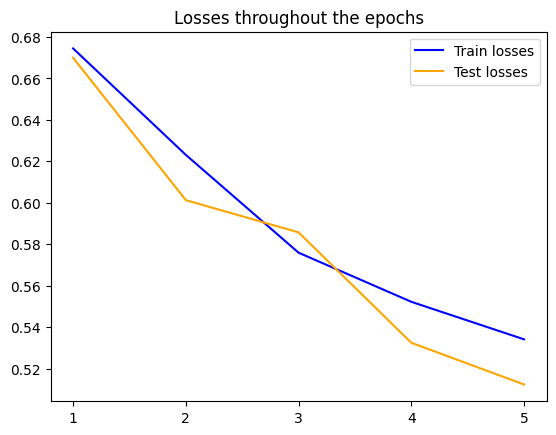

In [172]:
plt.plot(np.arange(1, num_epochs+1), train_losses, color="blue", label="Train losses")
plt.plot(np.arange(1, num_epochs+1), test_losses, color="orange", label="Test losses")

plt.title("Losses throughout the epochs")
plt.xticks(np.arange(1, num_epochs+1, 1))

plt.legend()
plt.show()

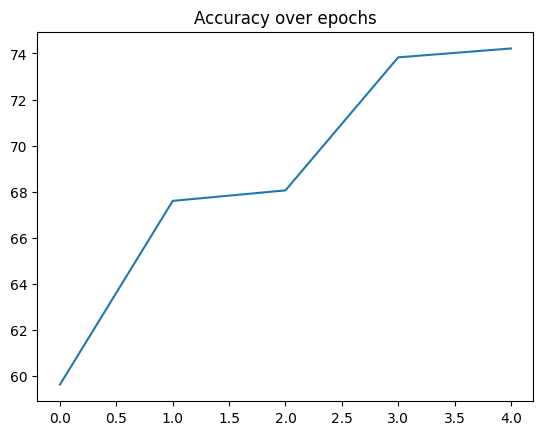

In [173]:
plt.title("Accuracy over epochs")
plt.plot(accuracies)